# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats as st
import seaborn as sns
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') # разделим склеенные данные знаком табуляции 
display(data.head())
data.info()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

Перед проведением анализа исходные данные необходимо предобработать:
- привести названия столбцов **cityCenters_nearest**, **parks_around3000** и **ponds_around3000** к единому "змеиному регистру";            
- больше половины из всех столбцов имееют пропущенные значения, пропуски необходимо обработать;
- следует заменить тип значений в столбцах:
   * на целочисленный тип стоит заменить значения многих столбцов, знаки после запятой в которых отсутствуют
   * **is_apartment** на булевый
   * **first_day_exposition** на datetime;
- проверить на наличие дубликатов и удалить их при наличии.

## Предобработка данных

Приведем к "змеиному регистру" названия вышеупомянутых столбцов датасета

In [84]:
data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest',
                            'parks_around3000': 'parks_around_3000',
                           'ponds_around3000': 'ponds_around_3000'}
                  )

Для поиска аномальных значений и ошибок проверим значения каждого из столбцов, где отсутствуют явные пропуски по порядку.

In [85]:
data['total_images'].value_counts() # оставим без изменений

10    1798
9     1725
20    1694
8     1585
7     1521
6     1482
11    1362
5     1301
12    1225
0     1059
13    1015
14     986
4      986
15     948
1      872
3      769
16     761
17     650
18     642
2      640
19     603
23      16
21      12
24       8
22       8
26       5
28       4
32       4
50       3
29       3
31       2
35       2
30       2
27       2
37       1
39       1
25       1
42       1
Name: total_images, dtype: int64

In [86]:
data['last_price'].value_counts() 
data['last_price'] = data['last_price'].astype('int') # для удобства просмотра приведем тип данных в этом столбце к целочисленному

In [87]:
data['total_area'].value_counts() # без изменений

45.00     419
42.00     383
60.00     347
31.00     346
44.00     345
         ... 
45.85       1
44.18       1
59.83       1
127.20      1
23.55       1
Name: total_area, Length: 2182, dtype: int64

In [88]:
display(data['first_day_exposition'].value_counts()) # время не указано, приведем тип к формату даты
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')

2018-02-01T00:00:00    368
2017-11-10T00:00:00    240
2017-10-13T00:00:00    124
2017-09-27T00:00:00    111
2018-03-26T00:00:00     97
                      ... 
2015-05-17T00:00:00      1
2017-02-25T00:00:00      1
2016-12-10T00:00:00      1
2016-07-21T00:00:00      1
2016-07-06T00:00:00      1
Name: first_day_exposition, Length: 1491, dtype: int64

In [89]:
display(data['rooms'].value_counts()) # допустим существование 15-, 16-, 19-ти комнатных квартир и оставим столбец без изменений 
data[data['studio']==True].head() # 0 комнат - это квартиры студии

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
14       2
11       2
19       1
12       1
16       1
15       1
Name: rooms, dtype: int64

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
144,1,2450000,27.00,2017-03-30,0,NaN,24.0,15.50,2,NaN,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0
440,8,2480000,27.11,2018-03-12,0,NaN,17.0,24.75,4,NaN,...,NaN,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0
608,2,1850000,25.00,2019-02-20,0,NaN,10.0,NaN,7,NaN,...,NaN,NaN,посёлок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0
697,12,2500000,24.10,2017-12-01,0,2.75,25.0,17.50,21,NaN,...,NaN,NaN,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,201.0
716,5,1500000,17.00,2017-06-07,0,2.70,9.0,12.00,1,NaN,...,NaN,0.0,посёлок Шушары,18654.0,29846.0,0.0,NaN,0.0,NaN,40.0


In [90]:
data['floor'].value_counts() # без изменений

2     3368
3     3073
1     2917
4     2804
5     2621
6     1305
7     1218
8     1083
9     1051
10     687
12     526
11     523
13     379
15     343
14     337
16     315
17     227
18     178
19     147
21     125
22     113
20     110
23     100
24      63
25      46
26      24
27      10
28       1
33       1
29       1
30       1
32       1
31       1
Name: floor, dtype: int64

In [91]:
data['studio'].value_counts() # квартир-студий мало, похоже на правду

False    23550
True       149
Name: studio, dtype: int64

In [92]:
data['open_plan'].value_counts() # со свободной планировкой ещё меньше

False    23632
True        67
Name: open_plan, dtype: int64

Далее приступим к обработке столбцов, где имеются явные пропуски:
- в столбце **ceiling_height** около половины строк имеют пропуски, если пропущенные значения заменить на медианное или среднее по столбцу, это может значительно исказить конечный результат, поэтому столбец **ceiling_height** лучше оставить без изменений
- здесь же присутствуют неправдоподобные значения (менее 2-ух и более 5-и метров), но их количество незначительно, поэтому можно эти выбросы также оставить без изменений 

In [93]:
display(data['ceiling_height'].describe())
display(len(data[data['ceiling_height'] > 5]))
display(len(data[data['ceiling_height'] < 2]))

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

36

3

- в столбце **floors_total** количество пропущенных значений незначительно, имеет смысл заменить пропуски на медианное значение (9 этажей)
- для удобства просмотра данных приведем тип данных этого столбца к целочисленному

In [94]:
display(data['floors_total'].describe())
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median()).astype('int')

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

- в столбце **living_area** для заполнения пропусков найдем отношение среднего значения жилой площади к среднему значению общей площади по всему датасету
- округлим значения до сотых, в лишних знаках после запятой нет необходимости

In [95]:
k = data['living_area'].mean()/data['total_area'].mean()
data['living_area'] = data['living_area'].fillna(data['total_area']*k)
data['living_area'] = data['living_area'].round(2)

- можно предположить, что столбец **is_apartment** стал заполняться с появлением апартаментов на рынке, раньше их не было, соответственно пропущенные значения - не апартаменты. Заменим пропуски на False и приведем тип значений к булевому

In [96]:
display(data['is_apartment'].value_counts())
data['is_apartment'] = data['is_apartment'].fillna(False).astype('bool')

False    2725
True       50
Name: is_apartment, dtype: int64

- пропуски в столбце **kitchen_area** заменим по тому же принципу, как и в столбце **living_area**

In [97]:
k = data['kitchen_area'].mean()/data['total_area'].mean()
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area']*k)

- можно предположить, что пропущеннные значения в столбце **balcony** - это их отсутствие, поэтому изменим пропуски на 0 и приведем тип данных к *int*                  

In [98]:
display(data['balcony'].unique())
data['balcony'] = data['balcony'].fillna(0).astype('int')

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

- в столбце **locality_name** нечем заменить пропущенные значения, но есть смысл избавиться от типа населенного пункта, оставив лишь его название, которое указано в датасете с заглавной буквы        

In [99]:
display(data['locality_name'].value_counts())
data['locality_name'] = data.locality_name.fillna(' ').apply(
    lambda title: ' '.join(word for word in title.split(' ') if not word.islower())
)
data['locality_name'].unique()

Санкт-Петербург                      15721
посёлок Мурино                         522
посёлок Шушары                         440
Всеволожск                             398
Пушкин                                 369
                                     ...  
садовое товарищество Приладожский        1
коттеджный поселок Счастье               1
деревня Новолисино                       1
посёлок Платформа 69-й километр          1
поселок Сумино                           1
Name: locality_name, Length: 364, dtype: int64

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

- в столбцах **airports_nearest**, **city_centers_nearest**, **parks_nearest** и  **ponds_nearest** у многих населенных пунктов нет информации по расстоянию до объекта, поэтому заменить пропуски не представляется возможным.

In [100]:
columns = ['airports_nearest', 'city_centers_nearest', 'parks_nearest', 'ponds_nearest']
for column in columns:
    
    display(data.groupby('locality_name')[column].mean().sort_values())


locality_name
Александровская    12896.500000
Шушары             16061.458716
Пушкин             16447.869919
Петро-Славянка     20605.000000
Павловск           21053.342105
                       ...     
Юкки                        NaN
Ялгино                      NaN
Яльгелево                   NaN
Ям-Тесово                   NaN
Янино-1                     NaN
Name: airports_nearest, Length: 306, dtype: float64

locality_name
                   11278.902439
Санкт-Петербург    11601.291571
Парголово          19924.776758
Мурино             21888.000000
Стрельна           23376.113636
                       ...     
Юкки                        NaN
Ялгино                      NaN
Яльгелево                   NaN
Ям-Тесово                   NaN
Янино-1                     NaN
Name: city_centers_nearest, Length: 306, dtype: float64

locality_name
Зеленогорск    210.625000
Кронштадт      324.574713
Павловск       379.538462
Ломоносов      389.062500
Пушкин         404.297170
                  ...    
Юкки                  NaN
Ялгино                NaN
Яльгелево             NaN
Ям-Тесово             NaN
Янино-1               NaN
Name: parks_nearest, Length: 306, dtype: float64

locality_name
Мурино        133.000000
Белоостров    320.000000
Кронштадт     343.413793
Сестрорецк    397.977778
Сапёрный      426.833333
                 ...    
Юкки                 NaN
Ялгино               NaN
Яльгелево            NaN
Ям-Тесово            NaN
Янино-1              NaN
Name: ponds_nearest, Length: 306, dtype: float64

- в столбцах **parks_around_3000** и **ponds_around_3000**, как и в столбце с балконами, предположим, что пропуск - это отсутствие парка/водоема, заменим пропуски на 0 и приведем тип данных к *int*

In [101]:
display(data['parks_around_3000'].unique())
data['parks_around_3000'] = data['parks_around_3000'].fillna(0).astype('int')
display(data['ponds_around_3000'].unique())
data['ponds_around_3000'] = data['ponds_around_3000'].fillna(0).astype('int')

array([ 1.,  0.,  2., nan,  3.])

array([ 2.,  0.,  3.,  1., nan])

- пропуски в столбце **days_exposition** никак не связать со столбцом **first_day_exposition**, посчитать и заполнить пропущенные значения невозможно. Заменим их нулевым значением и приведем тип значений к *int*

In [102]:
display(data[data['days_exposition'].isna()].head())
display(data['days_exposition'].value_counts())
data['days_exposition'] = data['days_exposition'].fillna(0).astype('int')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.00,8,False,...,25.000000,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
7,5,7915000,71.6,2019-04-18,2,NaN,24,40.88,22,False,...,18.900000,2,Санкт-Петербург,23982.0,11634.0,0,NaN,0,NaN,NaN
44,13,5350000,40.0,2018-11-18,1,NaN,22,22.84,3,False,...,7.005828,1,Санкт-Петербург,30471.0,11603.0,1,620.0,1,1152.0,NaN
45,17,5200000,50.6,2018-12-02,2,2.65,9,30.30,7,False,...,7.000000,0,Санкт-Петербург,30011.0,12872.0,0,NaN,0,NaN,NaN
46,17,6600000,52.1,2019-01-31,2,2.60,24,29.70,9,False,...,8.300000,2,Санкт-Петербург,15114.0,12702.0,0,NaN,0,NaN,NaN


45.0      880
60.0      538
7.0       234
30.0      208
90.0      204
         ... 
1110.0      1
1049.0      1
951.0       1
693.0       1
773.0       1
Name: days_exposition, Length: 1141, dtype: int64

In [103]:
data.info()
display("Количество дубликатов в таблице:", data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null int64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23699 non-null int64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null int64
locality_name           23699 non-null object
airports_nearest        18157 non-null float64
city_centers_nearest    18180 non-null float64
parks_around_3000       23699 non-null int64
parks_nearest           8079 non-null float64
ponds_around_300

'Количество дубликатов в таблице:'

0

После обработки полученных данных мы избавились от пропусков в большинстве столбцов. Оставшиеся пропуски востановить нет возможности, изменение либо их удаление может повлиять на общую картину, поэтому оставляем их без изменений. Дубликатов в таблице нет, можно переходить к следующему этапу.

## Расчёты и добавление результатов в таблицу

1. Посчитать цену квадратного метра:
- *разделим стоимость на общую площадь жилья*

In [104]:
data['price_per_square_meter'] = data['last_price'] / data['total_area']
data['price_per_square_meter'] = data['price_per_square_meter'].astype('int')

2. Найти день недели, месяц и год публикации объявления:
- *вытащим эти данные из столбца **first_day_exposition** при помощи функции .dt*

In [105]:
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday 
#data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year 

data['month_exposition'] = data['first_day_exposition'].astype('datetime64[M]')
data['year_exposition'].head()

0    2019
1    2018
2    2015
3    2015
4    2018
Name: year_exposition, dtype: int64

3. Категоризировать квартиры по этажу на три варианта — первый, последний, другой:
- *для категоризации квартир по этажу применим функцию для одной строки*

In [106]:
def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    if floor == floors_total:
        return 'последний'
    else:
        return 'другой'
data['floor_category'] = data.apply(floor_category, axis = 1)

4. Посчитать соотношение жилой и общей площади, а также отношение площади кухни к общей:
- *мы это делали ранее для заполнения пропусков в столбцах с жилой площадью и площадью кухни, посчитаем также и округлим значения до сотых*

In [107]:
data['living_area_ratio'] = data['living_area'] / data['total_area']
data['living_area_ratio'] = data['living_area_ratio'].round(2)
data['kitchen_area_ratio'] = data['kitchen_area'] / data['total_area']
data['kitchen_area_ratio'] = data['kitchen_area_ratio'].round(2)

In [108]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around_3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,year_exposition,month_exposition,floor_category,living_area_ratio,kitchen_area_ratio
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.00,8,False,...,2,755.0,0,120370,3,2019,2019-03-01,другой,0.47,0.23
1,7,3350000,40.4,2018-12-04,1,NaN,11,18.60,1,False,...,0,NaN,81,82920,1,2018,2018-12-01,первый,0.46,0.27
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.30,4,False,...,2,574.0,558,92785,3,2015,2015-08-01,другой,0.61,0.15
3,0,64900000,159.0,2015-07-24,3,NaN,14,90.79,9,False,...,3,234.0,424,408176,4,2015,2015-07-01,другой,0.57,0.18
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.00,13,False,...,1,48.0,121,100000,1,2018,2018-06-01,другой,0.32,0.41


После добавления результатов расчетов итоговая таблица имеет 29 колонок и пригодна для дальнейшего исследовательского анализа.

## Исследовательский анализ данных

**Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра.**

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

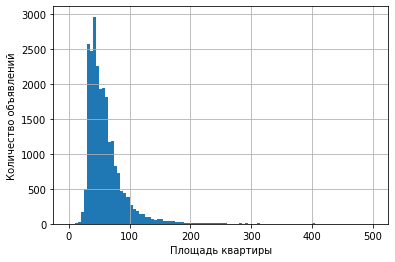

In [109]:
data['total_area'].hist(bins = 100, range = (0,500))
plt.ylabel("Количество объявлений")
plt.xlabel("Площадь квартиры")
data['total_area'].describe()

- Площадь

Исходя из полученных данных мы видим распределение Гаусса. Большая часть квартир имеют общую площадь в диапазоне 35 - 70 кв.м., после указанного диапазона с увеличением площади количество квартир снижается.   

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

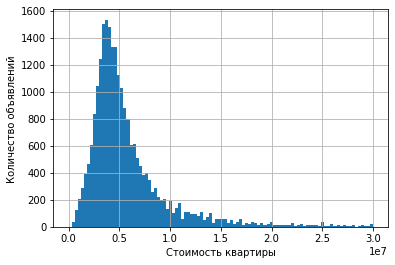

In [110]:
data['last_price'].hist(bins = 100, range = (0,30000000))
plt.ylabel("Количество объявлений")
plt.xlabel("Стоимость квартиры")
data['last_price'].describe()

- Цена

Здесь также наблюдается распределение данных Гаусса. Средняя стоимость квартир 6,5 млн., основная часть квартир оценивается от 3 до 7 млн, пик по количеству приходится на квартиры стоимостью около 4 млн.

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

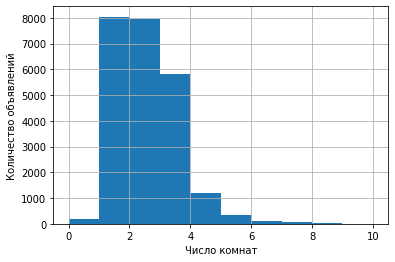

In [111]:
data['rooms'].hist(bins = 10, range = (0,10))
plt.ylabel("Количество объявлений")
plt.xlabel("Число комнат")
data['rooms'].describe()

- Число комнат

На рынке преобладают одно- и двух- комнатные квартиры, трехкомнатных квартир меньше, но их количество достаточно велико, небольшую долю рынка занимают четырехкомнатные квартиры. Квартир с большим количеством комнат (от 5 и выше), а также квартир-студий (0 комнат) относительно мало.

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

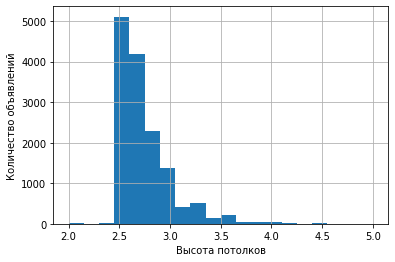

In [112]:
data['ceiling_height'].hist(bins = 20, range = (2,5))
plt.ylabel("Количество объявлений")
plt.xlabel("Высота потолков")
data['ceiling_height'].describe()

- Высота потолков

Большинство квартир имеют высоту потолков в диапазоне от 2,4 м. до 2,8 м. Выбросы (такие как 100 м.) влияют на средний показатель высоты потолков в большую сторону, но на гистограмме видно, что больше всего квартир имеют высоту потолков около 2,5 м. Квартир с высокими потолками (более 3 м.) относительно немного.  

**Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?**

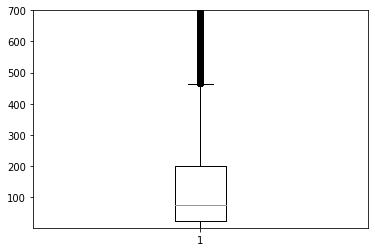

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

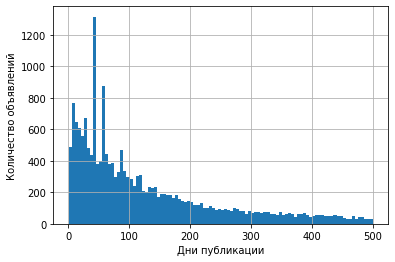

In [113]:
import matplotlib.pyplot as plt
plt.boxplot(data['days_exposition']) # строим диаграмму размаха
plt.ylim(1,700)
plt.show()
data['days_exposition'].hist(bins = 100, range = (1,500)) # строим гистограмму
plt.ylabel("Количество объявлений")
plt.xlabel("Дни публикации")
display(data[data['days_exposition']!=0]['days_exposition'].describe()) 

По полученным диаграмме размаха и гистограмме можно сказать, что нормальные значения дней продажи не превышают 500 дней, большинство квартир продаются в течении 200 дней с даты публикации объявления. Продажи можно считать быстрыми, если они прошли в течении 30 дней с даты публикации, а вот необычно долго продаются квартиры более 200 дней.
Среднее значение равно 180 дней, медианое - 95 дней. Такое относительно небольшое значение видимо связано с выбивающимися значениями, которые видны на гистограмме. Определим их и построим новую гистограмму без выбросов. 

**Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили.**

По гистограмме видно, что выбросы приходятся на первые 100 дней с момента публикации объявления. Построим новую гистограмму с диапазоном от 1 до 100 дней

45      880
60      538
7       234
30      208
90      204
       ... 
807       1
871       1
951       1
999       1
1223      1
Name: days_exposition, Length: 1141, dtype: int64

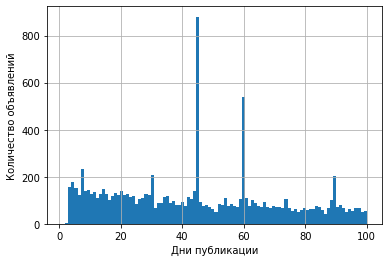

In [114]:
data['days_exposition'].hist(bins = 100, range = (1,100))
plt.ylabel("Количество объявлений")
plt.xlabel("Дни публикации")
data[data['days_exposition']!=0]['days_exposition'].value_counts()

Выбросы приходятся на 7, 30, 45, 60 и 90 дней с даты публикации объявления. Подозрительно, что эти числа совпадают с количеством дней в неделе, 1, 1,5, 2 и 3 месяца соответственно. Возможно это связано с правилами публикации объявлений на сайте, т.е. бесплатный период либо оплаченный срок публикации мог длиться такое время, а по окончанию, в случае непродления, объявление снималось с публикации, но квартира фактически не была продана.

Построим новую гистограмму без выпадающих значений, создав новый датасет без выбросов.

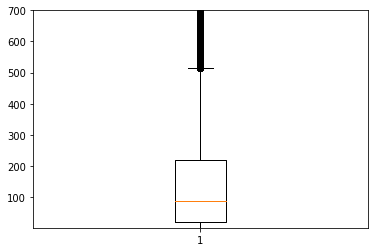

count    18454.000000
mean       195.803349
std        226.760010
min          1.000000
25%         44.000000
50%        114.000000
75%        259.000000
max       1580.000000
Name: days_exposition, dtype: float64

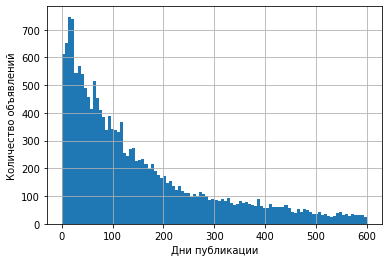

In [115]:
data_new = data.query('days_exposition != 7 & days_exposition != 30 & days_exposition != 45 & days_exposition != 60 & days_exposition != 90')
plt.boxplot(data_new['days_exposition'])
plt.ylim(1,700)
plt.show()
data_new['days_exposition'].hist(bins = 100, range = (1,600))
plt.ylabel("Количество объявлений")
plt.xlabel("Дни публикации")
data_new[data_new['days_exposition']!=0]['days_exposition'].describe()

Ожидаемо, в очищенных от выбросов данных, ярко выраженных скачков гистограммы нет, диапазон нормальных значений увеличился,  с увеличием количества дней публикации объявления плавно снижается количество проданных квартир, увеличились средние и медианное значения. Теперь можно сделать вывод, что большинство квартир продаются около 50 - 250 дней, быстрой можно считать продажу в течении первых 50 дней, а долгой - более 250 дней.

**Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от площади, числа комнат, удалённости от центра. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года.**

- Зависимость цены от площади

Для ответа на этот вопрос построим диаграмму рассеяния зависимости медианного значения стоимости квадратного метра от общей площади квартиры.  

0.30196014387792547

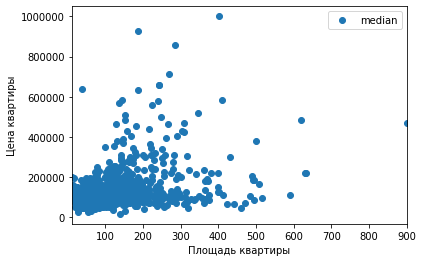

In [116]:
# создаем сводную таблицу
pivot_table_total_area = data.pivot_table(index = 'total_area', values = 'price_per_square_meter', aggfunc = ['median', 'count'])
pivot_table_total_area.columns = ['median', 'count']
# строим диаграмму 
pivot_table_total_area.plot(y = 'median', style = 'o')
plt.ylabel("Цена квартиры")
plt.xlabel("Площадь квартиры")
# вычисляем корреляцию Пирсона
data['total_area'].corr(data['price_per_square_meter'])

Согласно полученным результатам, зависимость стоимости квартиры от общей площади прямо пропорциональная, но ее значение (коэффициент корреляции) невелико - 0,3.

- Зависимость цены от числа комнат

Построим диаграмму зависимости стоимости квадратного метра от числа комнат по медианным значениям, сделав срез данных так, чтобы отсечь редкие объявления (многокомнатные квартиры). 

0.0554194996705922

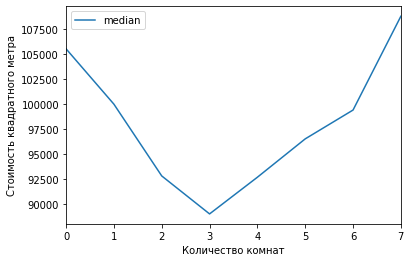

In [117]:
# создаем сводную таблицу
pivot_table_rooms = data.pivot_table(index = 'rooms', values = 'price_per_square_meter', aggfunc = ['median', 'count'])
pivot_table_rooms.columns = ['median', 'count']
# строим диаграмму по срезу (количество объявлений более 20)
pivot_table_rooms.query('count > 20').plot(y = 'median')
plt.ylabel("Стоимость квадратного метра")
plt.xlabel("Количество комнат")
# вычисляем корреляцию
data['rooms'].corr(data['price_per_square_meter'])

Здесь можно сделать следующий вывод: стоимость квадратного метра в квартирах с малым количеством комнат (менее трех) уменьшается при увеличении количества комнат, стоимость квадратного метра в 3-ех комнатных квартирах самая низкая, далее с увеличением количества комнат, стоимость квадратного метра возрастает.

- Зависимость стоимости от удаленности от центра

Для определения такой зависимости построим диаграмму рассеяния, для наглядности уменьшим прозрачность точек на диаграмме. 

-0.3179507368286467

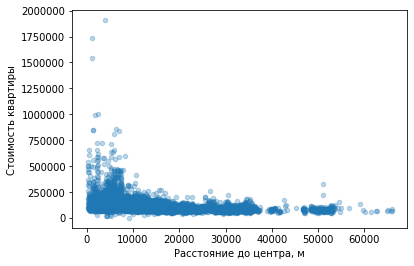

In [118]:
# строим диаграмму
data.plot(x = 'city_centers_nearest', y = 'price_per_square_meter', kind = 'scatter', alpha = 0.3)
plt.ylabel("Стоимость квартиры")
plt.xlabel("Расстояние до центра, м")
# вычислям корреляцию
data['city_centers_nearest'].corr(data['price_per_square_meter'])

По полученной диаграмме видим, что зависимость стоимости квартиры от удаленности от центра обратно пропорциональная, чем дальше от центра, тем дешевле, корреляция отрицательная.

- Зависимость стоимости от этажа

Text(0.5, 0, 'Категория по этажам')

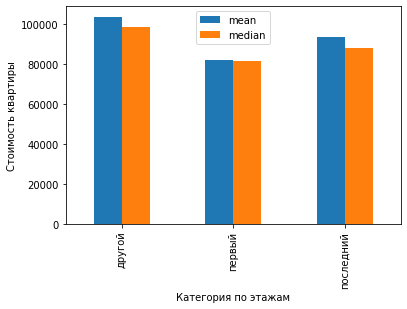

In [119]:
pivot_table_floor_category = data.pivot_table(index = 'floor_category', values = 'price_per_square_meter', aggfunc = ['mean', 'median'])
pivot_table_floor_category.columns = ['mean', 'median']
pivot_table_floor_category.plot(kind='bar')
plt.ylabel("Стоимость квартиры")
plt.xlabel("Категория по этажам")

На основе получившейся диаграммы можно сделать вывод, что стоимость квартир на первом этаже меньше, чем квартир на других этажах, квартиры на последнем этаже стоят также дешевле остальных, но при этом они немного дороже квартир первого этажа.

- Зависимость от даты размещения: день недели

Text(0.5, 0, 'Дни недели')

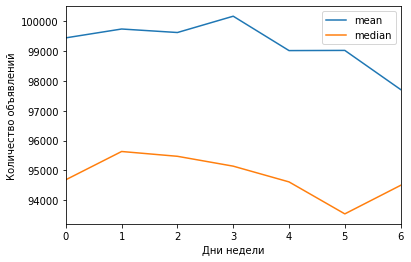

In [120]:
pivot_table_weekday_exposition = data.pivot_table(index = 'weekday_exposition', values = 'price_per_square_meter', aggfunc = ['mean', 'median'])
pivot_table_weekday_exposition.columns = ['mean', 'median']
pivot_table_weekday_exposition.plot()
plt.ylabel("Количество объявлений")
plt.xlabel("Дни недели")

График среднего и медианного значений ведут себя немного по разному, но общую тенденцию рассмотреть можно: активность в начале недели на рынке выше, видимо поэтому стоимость проданных квартир выше, к концу недели активность, а с ней и стоимость снижаются. 

- Зависимость от даты размещения: месяц

Text(0.5, 0, 'Месяц публикации')

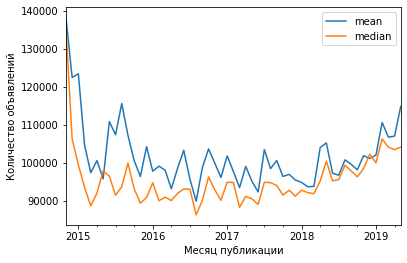

In [121]:
pivot_table_month_exposition = data.pivot_table(index = 'month_exposition', values = 'price_per_square_meter', aggfunc = ['mean', 'median'])
pivot_table_month_exposition.columns = ['mean', 'median']
pivot_table_month_exposition.plot()
plt.ylabel("Количество объявлений")
plt.xlabel("Месяц публикации")


Здесь поведение графиков медианного и среднего значений похожи: стоимость квартир с наступлением весны резко повышается, затем происходит резкий спад к лету, с началом осени стоимость снова подрастает, а перед приходом зимы - опять снижается. Такие скачки в данных происходят скорее всего из-за сезонной активности на рынке недвижимости: весной пик активности, который резко снижается во время летнего сезона отпусков, а далее с возвратом к осенней трудовой активности возрастает и активность на рынке. Зимой, само сабой, активность невелика, хотя она и выше, чем летом.

- Зависимость от даты размещения: год

Text(0.5, 0, 'Год публикации')

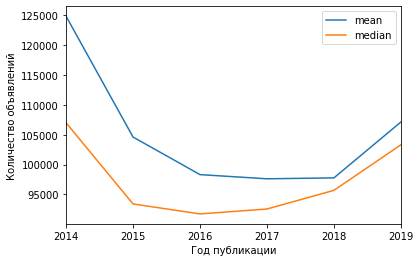

In [122]:
pivot_table_year_exposition = data.pivot_table(index = 'year_exposition', values = 'price_per_square_meter', aggfunc = ['mean', 'median'])
pivot_table_year_exposition.columns = ['mean', 'median']
pivot_table_year_exposition.plot()
plt.ylabel("Количество объявлений")
plt.xlabel("Год публикации")

Графики показывают четкую картину: после событий на политической арене 2014 года, на рынке недвижимости, как и в большинстве других сфер, наметился сильный спад, который продолжался вплоть до 2017 года, затем ситуация стала постепенно выправляться и в последний год (2019 по нашим данным), наблюдается рост стоимости квартир. 

1. Строим корреляцию:

In [123]:
data[['last_price', 'price_per_square_meter', 'total_area', 'rooms', 'city_centers_nearest']].corr()

,last_price,price_per_square_meter,total_area,rooms,city_centers_nearest
last_price,1.000000,0.736499,0.653675,0.363343,-0.206747
price_per_square_meter,0.736499,1.000000,0.301960,0.055419,-0.317951
total_area,0.653675,0.301960,1.000000,0.758344,-0.231446
rooms,0.363343,0.055419,0.758344,1.000000,-0.184864
city_centers_nearest,-0.206747,-0.317951,-0.231446,-0.184864,1.000000


2. По полученным значениям можно сделать следующий вывод:
- Стоимость квартиры прямо пропорционально зависит от общей площади и количества комнат, и обратно пропорционально от удаленности от центра города
- Величина коэффициента корреляции показывает, что на стоимость квартиры больше влияет ее площадь, чем количество комнат
- А вот зависимость стоимости квартиры от удаленности от центра незначительна, но все-таки присутствует
- Что касается стоимости квадратного метра, то он в меньшей степени зависит от общей площади и практически не зависит от количества комнат, а вот с отдалением от центра города стоимость метра квадратного уменьшается сильнее, чем общая стоимость квартиры

3. Визуализируем полученные значения:

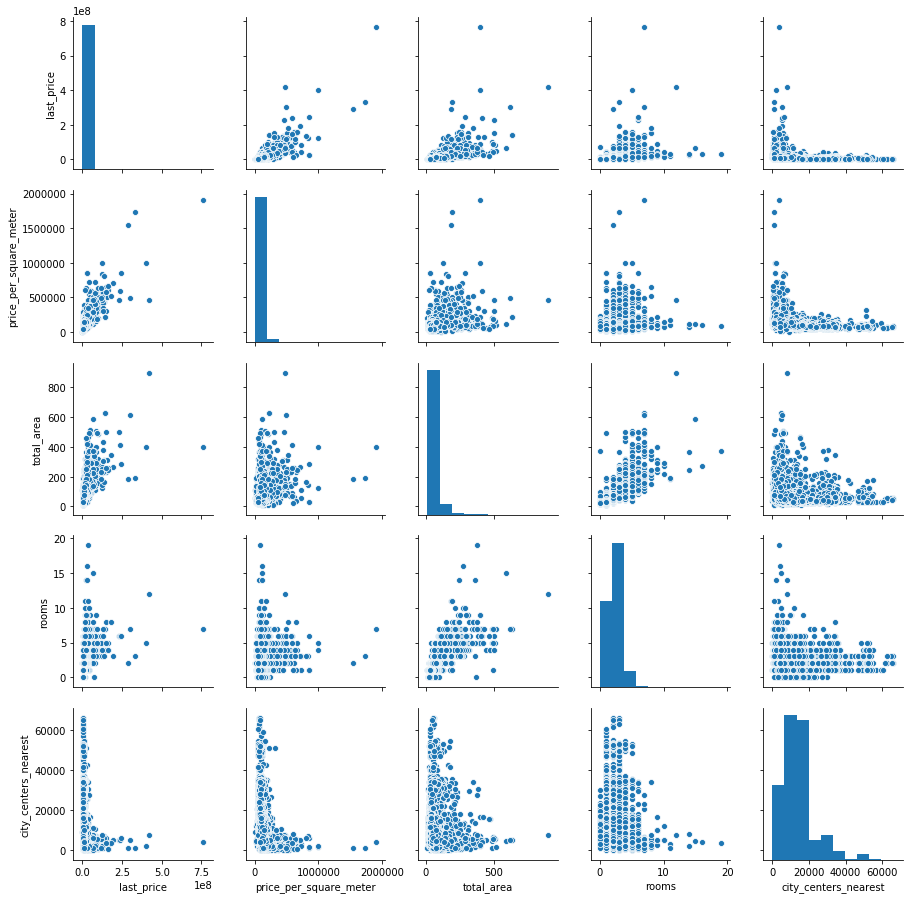

In [124]:
import seaborn as sns 

sns.pairplot(data[['last_price', 'price_per_square_meter', 'total_area', 'rooms', 'city_centers_nearest']]) 


Полученная матрица наглядно подтверждает описанный выше вывод.

**Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце locality_name.**

In [ ]:
# создадим сводную таблицу и отсортируем ее по количеству объявлений
locality_pivot_table = data.pivot_table(index = 'locality_name', values = 'price_per_square_meter', aggfunc=['count', 'mean'])
locality_pivot_table.columns = ['count', 'mean']
locality_pivot_table = locality_pivot_table.sort_values('count', ascending = False).head(10)
display(locality_pivot_table)
# самая высокая стоимость
display(locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].max()])
# самая низкая стоимость
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].min()]


Большинство объявлений приходится на Санкт-Петербург и его ближайшие окресные населенные пункты, исключение лишь город Выборг. Самая дорогая стоимость жилья в самом Питере, а самая дешевая из нашей выборки в Выборге (из-за наибольшей отдаленности от северной столицы).

**Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (locality_name). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется, — это и будет центральная зона.**

In [ ]:
# создадим столбец с расстоянием в км
data['city_centers_nearest_km'] = data['city_centers_nearest']/1000
# заменим пропуски выпадающим значеним и приведем тип ц целочисенному
data['city_centers_nearest_km'] = data['city_centers_nearest_km'].fillna(1000)
data['city_centers_nearest_km'] = data['city_centers_nearest_km'].astype('int')
# создадим совдную таблицу отобрав лишь объявления из Санкт_Петербурга и без выпадающих значений
pivot_table_km = data.query('locality_name == "Санкт-Петербург" and city_centers_nearest_km !=1000').pivot_table(index = 'city_centers_nearest_km', values = 'last_price', aggfunc = 'mean')
pivot_table_km.plot()
plt.ylabel("Стоимость квартиры")
plt.xlabel("Удаление от центра, км")

Судя по графику центральная зона в Санкт-Петербурге ограничена радиусом около 5 км, именно в этом месте график сильно меняется. Следующий скачок графика происходит где-то около 27 км от центра, но это расстояние слишком велико, скорее это некая линия пригородной застройки, где цены на новостройки по логике должны быть немного выше.

**Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?**

In [ ]:
# выделим объявления в центре Санкт-Петербурга, ограничив радиус в 5 км
center_spb_data = data.query('city_centers_nearest_km <= 5 and locality_name == "Санкт-Петербург"')

*Проанализируем площадь, цену, число комнат и высоту потолков, построив гистограммы по каждому из параметров*

In [ ]:
center_spb_data['total_area'].hist(bins = 100, range = (0,500))
plt.ylabel("Количество объявлений")
plt.xlabel("Площадь квартиры, м2")
center_spb_data['total_area'].describe()

In [ ]:
center_spb_data['last_price'] = center_spb_data['last_price']/1000000
center_spb_data['last_price'].hist(bins = 100, range = (0,30))
plt.ylabel("Количество объявлений")
plt.xlabel("Стоимость квартиры")
center_spb_data['last_price'].describe()

In [ ]:
center_spb_data['rooms'].hist(bins = 10, range = (0,10))
plt.ylabel("Количество объявлений")
plt.xlabel("Число комнат")
center_spb_data['rooms'].describe()

In [ ]:
center_spb_data['ceiling_height'].hist(bins = 20, range = (2,5))
plt.ylabel("Количество объявлений")
plt.xlabel("Высота потолков")
center_spb_data['ceiling_height'].describe()

Согласно полученным гистограммам можно выделить следующее:
- большая часть квартир имееют площадь от 60 до 110 кв.м., с увеличинием площади квартир, их количество сокращается
- большинство квартир в центре оцениваются в диапазоне от 7 до 15 млн, дорогих (более 15 млн.) квартир относительно немного
- в центре преобладают квартиры с 2-мя, 3-мя и 4-мя комнатами, однокомнатных квартир значительно меньше
- потолки квартир в центральной части достаточно высокие в большинстве своем, от 3 до 3,3 м.

*Проанализируем факторы, влияющие на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления)*


* Зависимость цены от количества комнат

In [ ]:
# создаем сводную таблицу
pivot_table_rooms = center_spb_data.pivot_table(index = 'rooms', values = 'price_per_square_meter', aggfunc = ['median', 'count'])
pivot_table_rooms.columns = ['median', 'count']
# строим диаграмму по срезу (количество объявлений более 20)
pivot_table_rooms.query('count > 20').plot(y = 'median')
plt.ylabel("Стоимость квартиры")
plt.xlabel("Количество комнат")
# вычисляем корреляцию
center_spb_data['rooms'].corr(data['price_per_square_meter'])

Зависимость цены от количества комнат незначительная, обратно пропорциональная. Корреляция совсем незначительная, но согласно графику с увеличением количества комнат, стоимость квадратного метра жилья уменьшается.

* Зависимость цены от этажа

In [ ]:
pivot_table_floor_category = center_spb_data.pivot_table(index = 'floor_category', values = 'price_per_square_meter', aggfunc = ['mean', 'median'])
pivot_table_floor_category.columns = ['mean', 'median']
pivot_table_floor_category.plot(kind='bar')
plt.ylabel("Стоимость квартиры")
plt.xlabel("Категория по этажу")

Квартиры первого этажа стоят дешевле всего, квартиры других этажей немного отличаются по стоимости с квартирами последнего этажа, связано это скорее всего с низкоэтажной застройкой в центре города.

* Зависимость цены от удаленности от центра

In [ ]:
# строим диаграмму
center_spb_data.plot(x = 'city_centers_nearest', y = 'price_per_square_meter', kind = 'scatter', alpha = 0.3)
plt.ylabel("Стоимость квартиры")
plt.xlabel("Удаленность от центра")
# вычислям корреляцию
center_spb_data['city_centers_nearest'].corr(data['price_per_square_meter'])

Зависимости стоимости квартиры в центральной части от удаленности от центра нет никакой, они и так находятся в центре))

* Зависимость цены от удаленности от даты размещения: день недели

In [ ]:
pivot_table_weekday_exposition = center_spb_data.pivot_table(index = 'weekday_exposition', values = 'price_per_square_meter', aggfunc = ['mean', 'median'])
pivot_table_weekday_exposition.columns = ['mean', 'median']
pivot_table_weekday_exposition.plot()
plt.ylabel("Стоимость квартиры")
plt.xlabel("День публикации")

Графики медианных и средних значений ведут себя по разному, установить зависимость стоимости квартиры от дня недели публикации объявления нет возможности, скорее всего такой зависимости нет.

* Зависимость цены от удаленности от даты размещения: месяц

In [ ]:
pivot_table_month_exposition = center_spb_data.pivot_table(index = 'month_exposition', values = 'price_per_square_meter', aggfunc = ['mean', 'median'])
pivot_table_month_exposition.columns = ['mean', 'median']
pivot_table_month_exposition.plot()
plt.ylabel("Стоимость квартиры")
plt.xlabel("Месяц публикации")

По аналогии с общим анализом всего датасета, здесь наблюдаются скачки стоимости квартир в зависимости от сезонной активности на рынке недвижимости: весной и осенью рост, летом и зимой спад.

* Зависимость цены от удаленности от даты размещения: год

In [ ]:
pivot_table_year_exposition = center_spb_data.pivot_table(index = 'year_exposition', values = 'price_per_square_meter', aggfunc = ['mean', 'median'])
pivot_table_year_exposition.columns = ['mean', 'median']
pivot_table_year_exposition.plot()
plt.ylabel("Стоимость квартиры")
plt.xlabel("Год публикации")

И здесь общая тенденция - спад после 2014 года, плато в 2017 году и рост до 2019 года.

**ВЫВОД:** показатели квартир в центральной части отличаются от общих показателей этого анализа:
- площадь квартир, количество комнат, высота потолков и стоимость квартир в центральной части выше, чем общие показатели по всей выборке
- на стоимость квартир в центре города практически не оказывают влияние, ни число комнат, ни этаж, ни удалённость от центра, ни день недели размещения объявления

Для анализа объявлений центральной части города, как и для всей базы данных в целом, корреляцию Пирсона можно построить для следующих столбцов: 

In [ ]:
ce|nter_spb_data[['last_price', 'price_per_square_meter', 'total_area', 'rooms', 'city_centers_nearest']].corr()

Визуализируем полученные значения:

In [ ]:
sns.pairplot(center_spb_data[['last_price', 'price_per_square_meter', 'total_area', 'rooms', 'city_centers_nearest']]) 

В результате мы видим:
- Зависимость стоимости квартиры от общей площади практически такая же, как и для всей базы объявлений
- Зависимость стоимости от числа комнат ниже, но тоже присутствует
- Зависимости стоимости от удаленности от центра практически нет (что логично)
- Зависимости стоимости квадратного метра жилья в центра практически нет ни от одного из вышеуказанных показателей

## Общий вывод

Полученный для анализа архив нуждался в предобработке, нами было проделано:
- изменили тип данных там, где это было возможно и необходимо для комфортной работы
- заменили пропущенные значения там, где это было логично и не искажало общую картину 
- вычислили и добавили в таблицу данные о цене квадратного метра
- вывели из даты дни недели, месяцы и годы публикации объявления
- провели категоризацию квартир по этажам

При проведении анализа обнаружили аномальные значения данных столбца о времени продажи квартир, продолжили аналииз исключив аномалии.

По результатам анализа можно составить описание среднестатистической квартиры: площадь около 60 кв.м., 2-ух комнатная, высота потолков около 2,8 м, стоимость около 6,5 млн.

На стоимость жилья в некоторой степени оказывают влияние такие факторы, как количество комнат, этаж, удаленность от центра, общая площадь, также имеет значение в какой день недели и месяц продавать квартиру - это связано с недельной или сезонной активностью на рынке недвижимости. 

Больше всего объявлений в нашем датасете приходится на Санкт_Петербург, здесь же и самое дорогое жилье.

Теоретически нам удалось примерно определить границу центральной части города (окружность радиусом 5 км). В центре среднестатистическая квартира имеет большую площадь, количество комнат, высоту потолков и стоимость, в отличии от средней квартиры по всему архиву. На стоимость квартиры в центре города в меньшей степени оказывают влияние факторы, которые упоминались выше для средне
